# Лабортаторная работа №2

### По курсу "нейроинформатика"

студент: Гаврилов М.С.  
группа: М8О-406Б-19  

##### Цель работы:
Исследование свойств линейной нейронной сети и алгоритмов ее обучения, применение сети в задачах аппроксимации и фильтрации

In [132]:
import numpy as np
import pylab

import torch
import torch.nn as nn
import copy

## 1. Аппроксимация сигнала

##### Функция, которую нужно аппроксимировать:

t ∈ [0, 3.5], h(lr) = 0.01

In [133]:
def function(t):
    return np.sin(t**2 - 15*t + 3) - np.sin(t)

In [134]:
line = np.array([[i/1000,function(i/1000)] for i in range (0,3500)])

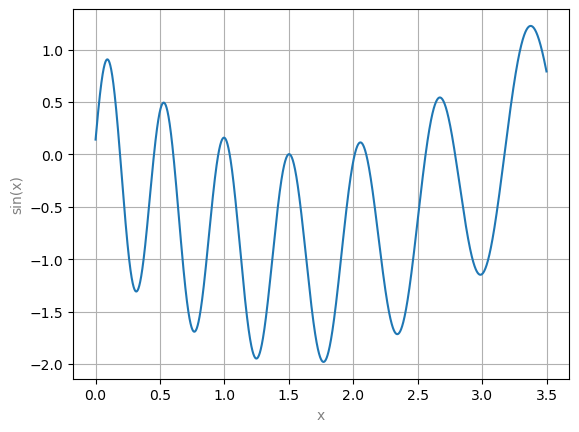

In [135]:
pylab.xlabel("x",color = "grey")
pylab.ylabel("sin(x)",color = "grey")
pylab.grid()
pylab.plot(line[:,0],line[:,1])
pylab.show()

##### Составление датасета:  
Берется D подряд идущих точек (Y координата) на кривой, и в качестве целевого вывода берется координата точки, идущей следом. 

In [136]:
def make_dataset(line,D = 5):
    train_X = []
    train_Y = []
    for i in range(len(line)):
        if(i > D - 1):
            tmp = []
            for j in range(D,0,-1):
                tmp.append(line[i - j][1])
            train_X.append(tmp)
            train_Y.append(line[i][1])

    train_X = torch.tensor(train_X,dtype = torch.float32)
    train_Y = torch.tensor(train_Y,dtype = torch.float)
    
    return train_X,train_Y

Будет использоваться функция обучения из прошлой лабораторной работы, так как в этот раз размер датасетов довольно большой, добавлена реализация биения на батчи.

In [137]:
def accuracy_adaline(testRS,testLB):
    return (np.sum(abs(testRS - testLB)))

def train(net,trainXX,trainLB,n_epochs,batch_size,lr,
         optimiser = torch.optim.SGD,
         criterion = torch.nn.MSELoss(),
         accuracy = accuracy_adaline
         ):
    #функция, производящая обучение сети
    arr = []
    
    optim = optimiser(model.parameters(),lr=lr)
    
    num_batches = len(trainXX)/batch_size
    
    for i in range(n_epochs):
                
        for j in range(int(num_batches)):
            batchXX = trainXX[j*batch_size : (j+1)*batch_size]
            batchLB = trainLB[j*batch_size : (j+1)*batch_size]
            
            optim.zero_grad()
            loss = criterion(model(batchXX),batchLB)
            loss.backward()
            optim.step()
            
        #трэйсинг обучения
        arr.append([i,
                    loss.detach().numpy(), #значение ф-и потерь
                    accuracy(model(trainXX).detach().numpy(),trainLB.detach().numpy())]) #среднее количество совпадений в предсказаниях (точность)
                    
    return np.array(arr)

In [138]:
def plot_learning(arr):
    pylab.xlabel("epochs",color = "grey")
    pylab.ylabel("loss",color = "grey")
    pylab.plot(arr[:,0],arr[:,1])
    pylab.show()
    
def plot_both(pts_exmpl,pts_res,aditional_plot = None):
    arr_res = np.array([[(i)/1000 ,pts_res[i]] for i in range(len(pts_res))])
    arr_exm = np.array([[(i)/1000 ,pts_exmpl[i]] for i in range(len(pts_exmpl))])
    
    if(not np.array(aditional_plot == None).all()):
        pylab.plot(aditional_plot[:,0],aditional_plot[:,1],color = "red")
    
    print("blue   - target    line")
    print("orange - predictrd line")
    pylab.xlabel("x",color = "grey")
    pylab.ylabel("f(x)",color = "grey")
    pylab.grid()
    pylab.plot(arr_exm[:,0],arr_exm[:,1],color = "blue",linewidth = 3)
    pylab.plot(arr_res[:,0],arr_res[:,1],color = "orange",linewidth = 1.5)
    pylab.show()

##### Обучнеине модели

В качестве функции потерь используется mse

In [139]:
D = 5
train_X,train_Y = make_dataset(line,D)

model = torch.nn.Sequential(
    nn.Linear(D,1),
    nn.Flatten(0,1)
)

arr = train(model,train_X,train_Y,100,100,0.01)

Кривая обучения и сравнение предсказаний с образцом:

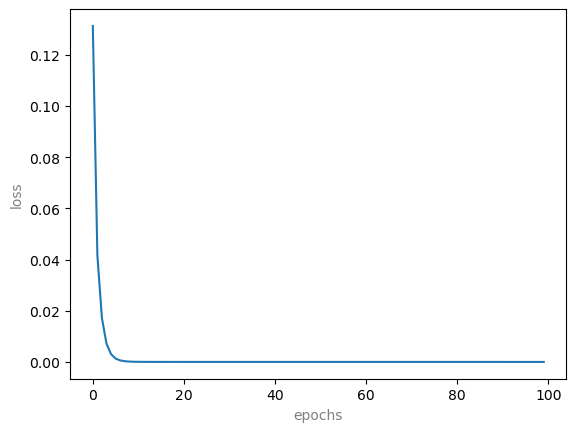

blue   - target    line
orange - predictrd line


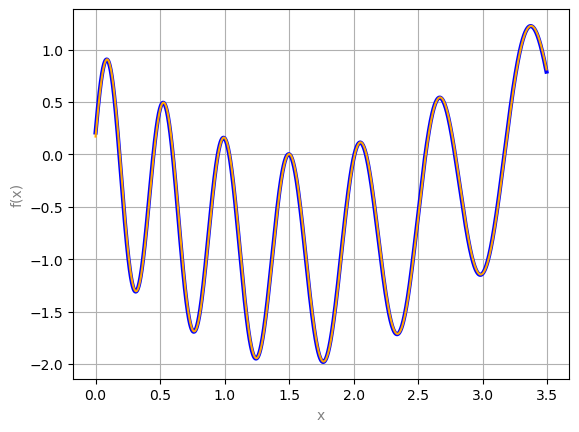

In [140]:
plot_learning(arr)
plot_both(train_Y,model(train_X).detach().numpy())

Сравнение точности обучения при разных значениях ширины окна

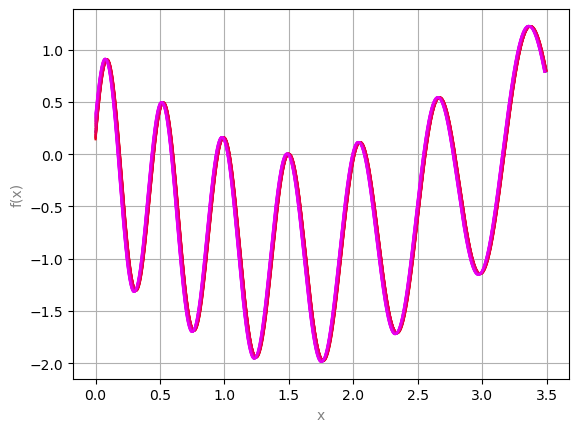

In [58]:
pts_exmpl = train_Y
arr_exm = np.array([[(i)/1000 ,pts_exmpl[i]] for i in range(len(pts_exmpl))])
pylab.plot(arr_exm[:,0],arr_exm[:,1],color = "blue")

for D in range (1,20):
    train_X,train_Y = make_dataset(line,D)

    model = torch.nn.Sequential(
        nn.Linear(D,1),
        nn.Flatten(0,1)
    )

    arr = train(model,train_X,train_Y,100,20,0.01,accuracy = accuracy_adaline)
    
    pts_res = model(train_X).detach().numpy()
    
    arr_res = np.array([[(i)/1000 ,pts_res[i]] for i in range(len(pts_res))])
    
    pylab.xlabel("x",color = "grey")
    pylab.ylabel("f(x)",color = "grey")
    pylab.grid()
    pylab.plot(arr_res[:,0],arr_res[:,1],color = [0.9,0.0,D/20])
    
pylab.show()

Видно, что особой разницы нет

## 2. Фильтрация сигнала

##### Искаженная и целевая функции:

t in [0,2.2], h = 0.01

In [66]:
def function(t):
    return (1/4)*np.cos(2.5*t**2 - 5*t + np.pi)

def target_function(t):
    return np.cos(2.5*t**2 - 5*t)

red  - corrupt signal
blue - target  signal


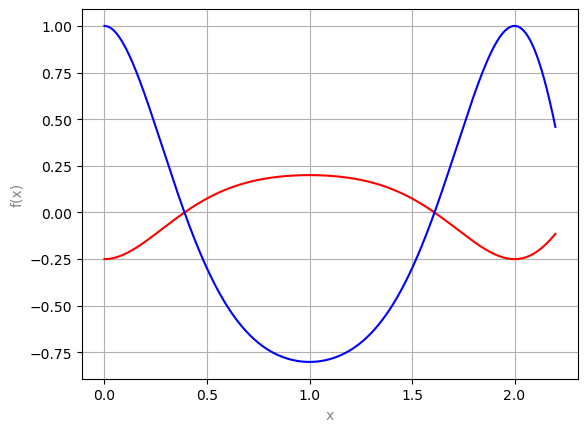

In [67]:
line = np.array([[i/1000,function(i/1000)] for i in range (0,2200)])
tg_line = np.array([[i/1000,target_function(i/1000)] for i in range (0,2200)])

print("red  - corrupt signal")
print("blue - target  signal")
pylab.xlabel("x",color = "grey")
pylab.ylabel("f(x)",color = "grey")
pylab.grid()
pylab.plot(line[:,0],line[:,1],color = "red")
pylab.plot(tg_line[:,0],tg_line[:,1],color = "blue")
pylab.show()

##### Составление датасета:  
В качестве входа дается набор из D последоательных точек искаженной функции, в качестве выхода - одна (следующая) точка целевой функции. Таким образом, обученная модель сможет рассчитать целевую функцию, получив на вход только точки искаженной.

In [79]:
def make_dataset(line,target_line,D = 5):
    train_X = []
    train_Y = []
    for i in range(len(line)):
        if(i > D - 1):
            tmp = []
            for j in range(D,0,-1):
                tmp.append(line[i - j][1])
            train_X.append(tmp)
            train_Y.append(target_line[i][1])

    train_X = torch.tensor(train_X,dtype = torch.float32)
    train_Y = torch.tensor(train_Y,dtype = torch.float)
    
    return train_X,train_Y

##### Обучение модели

In [80]:
D = 5
test_X,test_Y = make_dataset(line,tg_line,D)
trainXX = np.split(test_X,5)[0]
trainYY = np.split(test_Y,5)[0]

model = torch.nn.Sequential(
    nn.Linear(D,1),
    nn.Flatten(0,1)
)

arr = train(model,trainXX,trainYY,200,10,0.01,accuracy = accuracy_adaline)

На первом чертеже отображена та часть целевой функции, которая использовалась при обучении, на втором - вся целевая функция

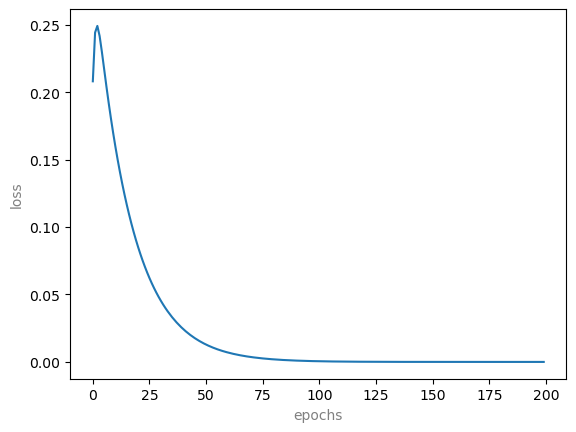

blue   - target    line
orange - predictrd line


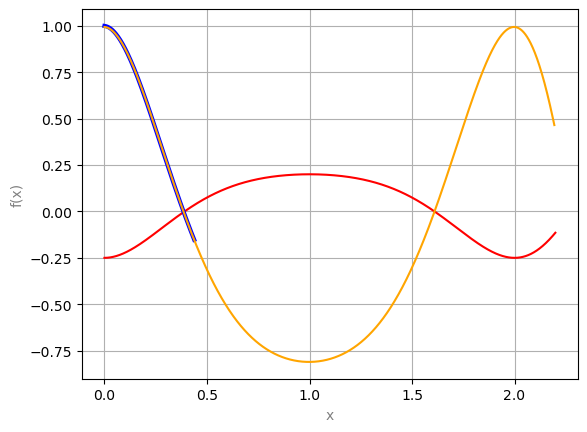

blue   - target    line
orange - predictrd line


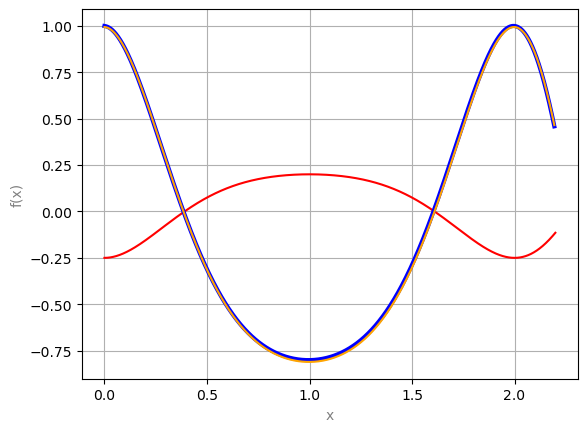

In [81]:
plot_learning(arr)
plot_both(trainYY,model(test_X).detach().numpy(),aditional_plot = line)
plot_both(test_Y,model(test_X).detach().numpy(),aditional_plot = line)

Сравнение точности фильтрации при разной длине фрагмента целевой функции, используемого при обучении:


Part of target used for train = 0.5

blue   - target    line
orange - predictrd line


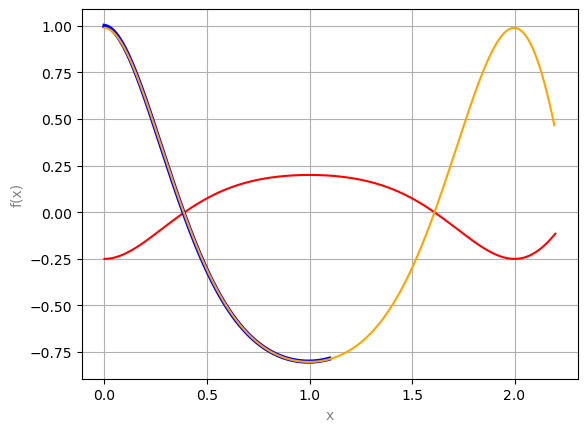

blue   - target    line
orange - predictrd line


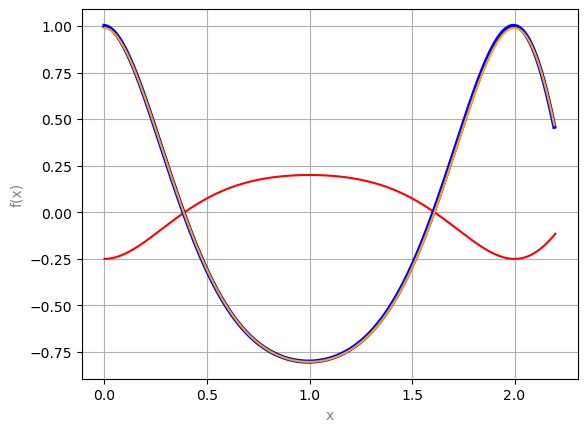

____________________________________________________

Part of target used for train = 0.2

blue   - target    line
orange - predictrd line


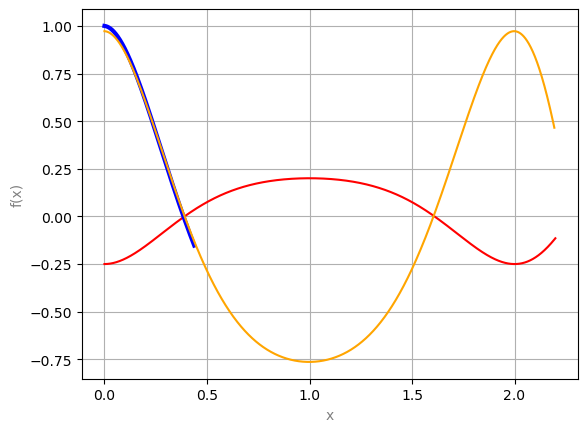

blue   - target    line
orange - predictrd line


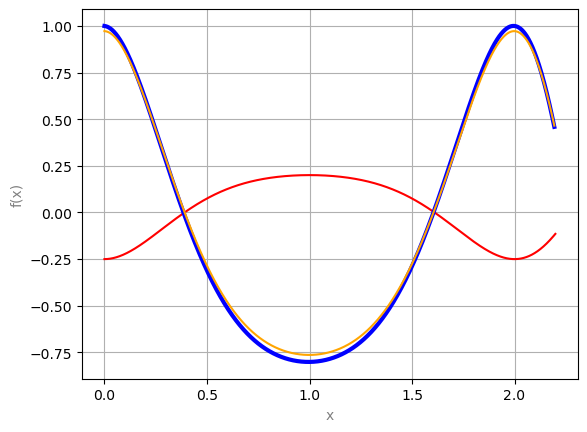

____________________________________________________

Part of target used for train = 0.1

blue   - target    line
orange - predictrd line


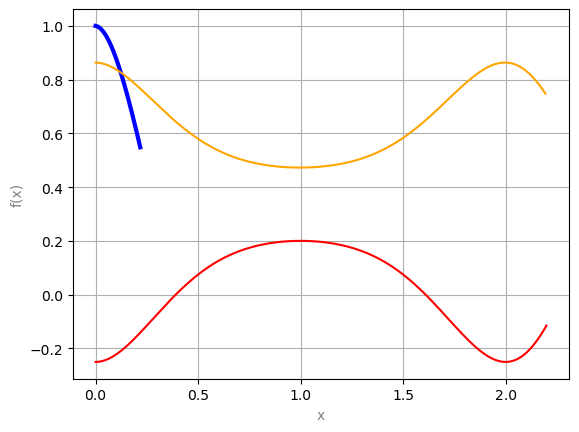

blue   - target    line
orange - predictrd line


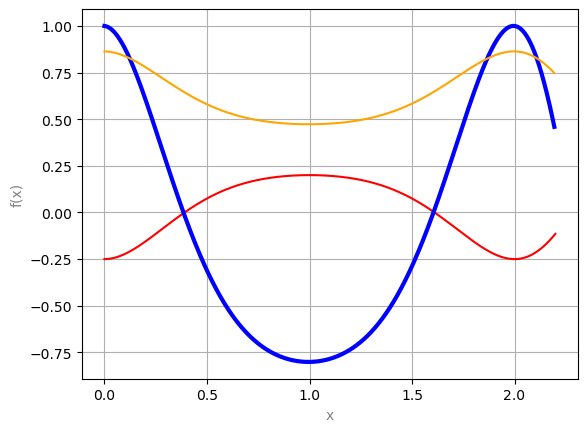

____________________________________________________

Part of target used for train = 0.05

blue   - target    line
orange - predictrd line


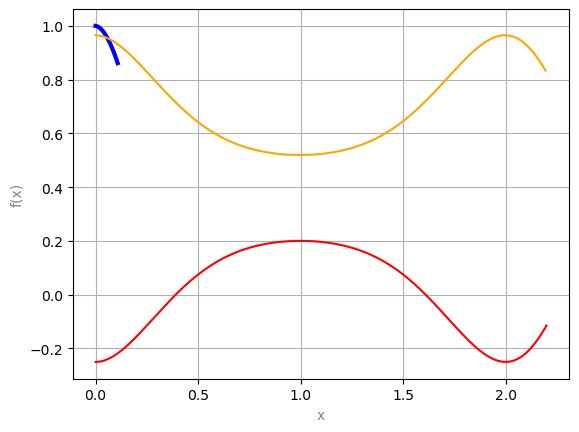

blue   - target    line
orange - predictrd line


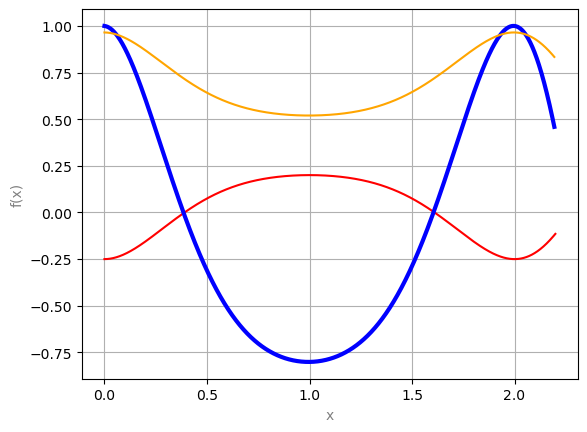

____________________________________________________

Part of target used for train = 0.01

blue   - target    line
orange - predictrd line


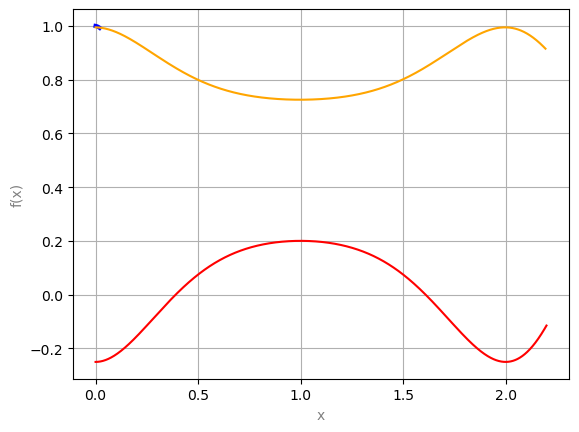

blue   - target    line
orange - predictrd line


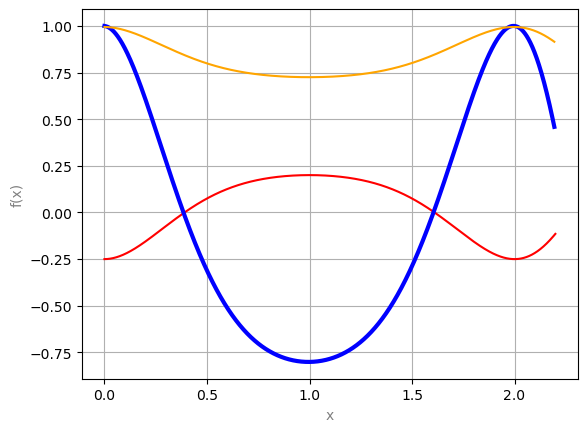

____________________________________________________


In [78]:
for splc in [0.5,0.2,0.1,0.05,0.01]:
    D = 5
    test_X,test_Y = make_dataset(line,tg_line,D)
    trainXX = np.split(test_X,[int(splc*len(test_X))])[0]
    trainYY = np.split(test_Y,[int(splc*len(test_X))])[0]

    model = torch.nn.Sequential(
        nn.Linear(D,1),
        nn.Flatten(0,1)
    )

    arr = train(model,trainXX,trainYY,100,10,0.01,accuracy = accuracy_adaline)
    
    print("\nPart of target used for train = {}\n".format(splc))
    plot_both(trainYY,model(test_X).detach().numpy(),aditional_plot = line)
    plot_both(test_Y,model(test_X).detach().numpy(),aditional_plot = line)
    print("____________________________________________________")

Видно, что, по крайней мере в данном примере, при использовании менее, чем пятой части целевой функции точность фильтрации крайне низка.

На примере adaline можно наглядно посмотреть, как функции активации влияет на вывод нейросети

In [89]:
def function(t):
    return np.sin(t**2 - 15*t + 3) - np.sin(t)

line = np.array([[i/1000,function(i/1000)] for i in range (0,4500)])

def make_dataset(line,D = 5):
    train_X = []
    train_Y = []
    for i in range(len(line)):
        if(i > D - 1):
            tmp = []
            for j in range(D,0,-1):
                tmp.append(line[i - j][1])
            train_X.append(tmp)
            train_Y.append(line[i][1])

    train_X = torch.tensor(train_X,dtype = torch.float32)
    train_Y = torch.tensor(train_Y,dtype = torch.float)
    
    return train_X,train_Y

##### Сигмоида

blue   - target    line
orange - predictrd line


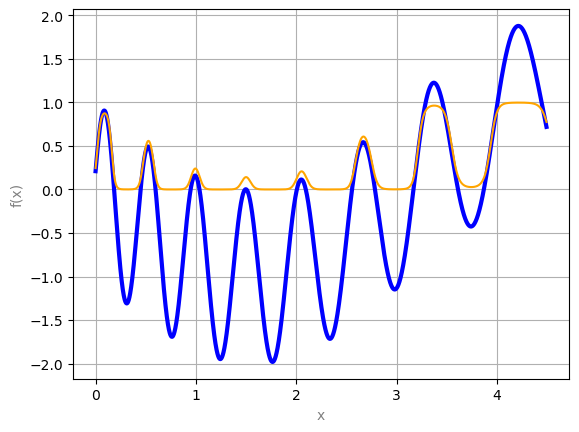

In [90]:
D = 5
train_X,train_Y = make_dataset(line,D)

model = torch.nn.Sequential(
    nn.Linear(D,1),
    nn.Sigmoid(),
    nn.Flatten(0,1)
)

arr = train(model,train_X,train_Y,100,100,0.01,accuracy = accuracy_adaline)

plot_both(train_Y,model(train_X).detach().numpy())

##### Гиперболический тангенс

blue   - target    line
orange - predictrd line


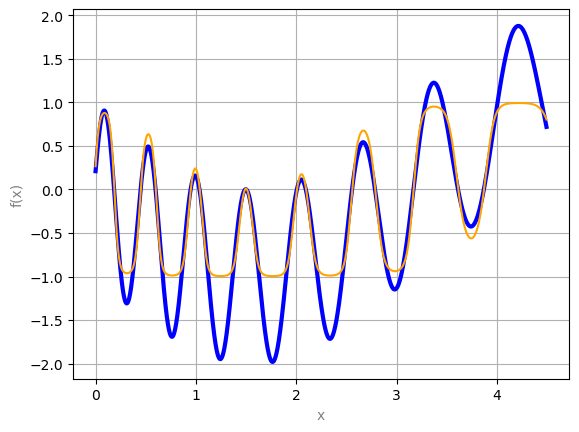

In [85]:
D = 5
train_X,train_Y = make_dataset(line,D)

model = torch.nn.Sequential(
    nn.Linear(D,1),
    nn.Tanh(),
    nn.Flatten(0,1)
)

arr = train(model,train_X,train_Y,100,100,0.01,accuracy = accuracy_adaline)

plot_both(train_Y,model(train_X).detach().numpy())

##### ReLU

blue   - target    line
orange - predictrd line


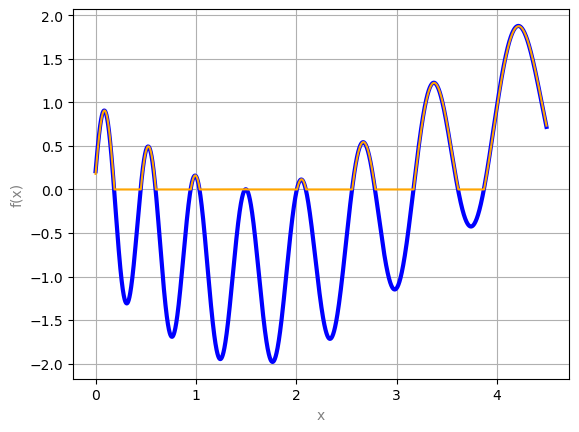

In [91]:
D = 5
train_X,train_Y = make_dataset(line,D)

model = torch.nn.Sequential(
    nn.Linear(D,1),
    nn.ReLU(),
    nn.Flatten(0,1)
)

arr = train(model,train_X,train_Y,100,100,0.01,accuracy = accuracy_adaline)

plot_both(train_Y,model(train_X).detach().numpy())

Видно, как результат применения модели не может выйти за границы области значений функции активации.

Интересно, что и при бесконечной области значений нелинейная функция активации будет мешать точной апроксимации. Пример с leaky ReLU, плавно переходящей в линейную функцию: 

##### LeakyReLU с разным параметром утечки

LReLU param = 0.01
blue   - target    line
orange - predictrd line


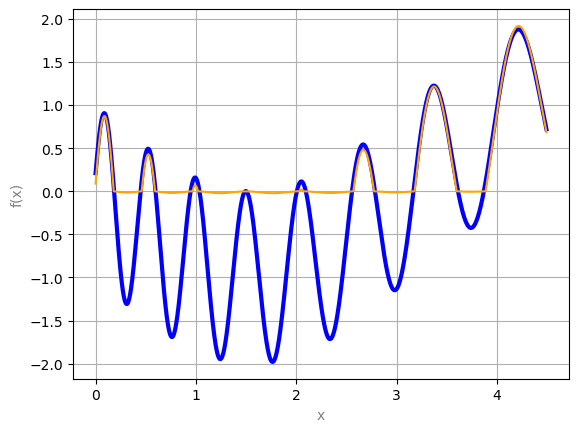

LReLU param = 0.05
blue   - target    line
orange - predictrd line


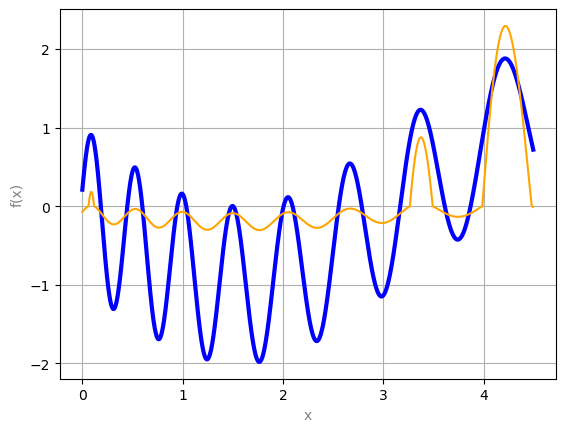

LReLU param = 0.1
blue   - target    line
orange - predictrd line


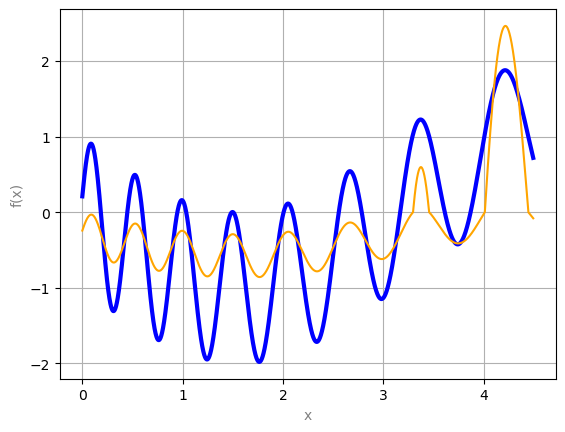

LReLU param = 0.5
blue   - target    line
orange - predictrd line


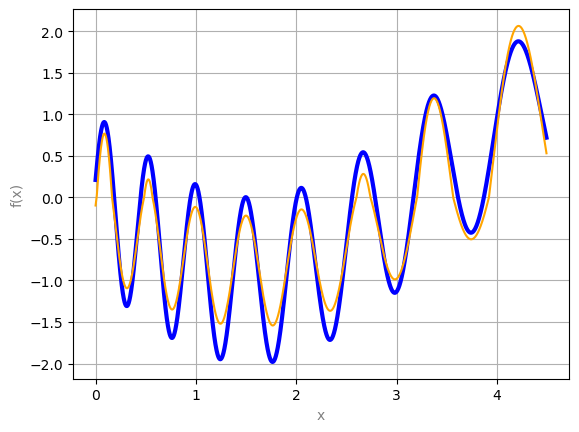

LReLU param = 1
blue   - target    line
orange - predictrd line


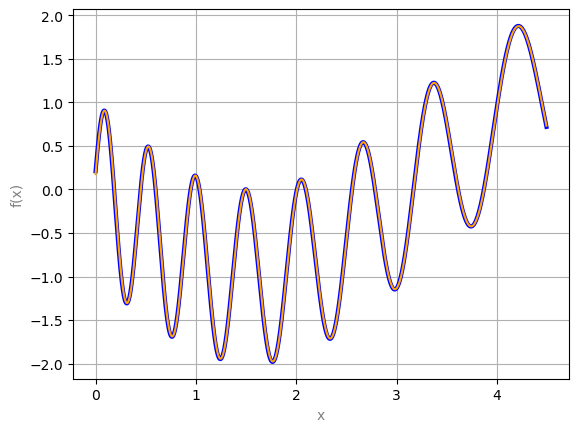

In [87]:
D = 5
train_X,train_Y = make_dataset(line,D)

for k in [0.01,0.05,0.1,0.5,1]:
    parm = k
        
    print("LReLU param = {}".format(parm))
    model = torch.nn.Sequential(
        nn.Linear(D,1),
        nn.LeakyReLU(parm),
        nn.Flatten(0,1)
    )

    arr = train(model,train_X,train_Y,100,100,0.01,accuracy = accuracy_adaline)

    plot_both(train_Y,model(train_X).detach().numpy())


##### Линейная функция

blue   - target    line
orange - predictrd line


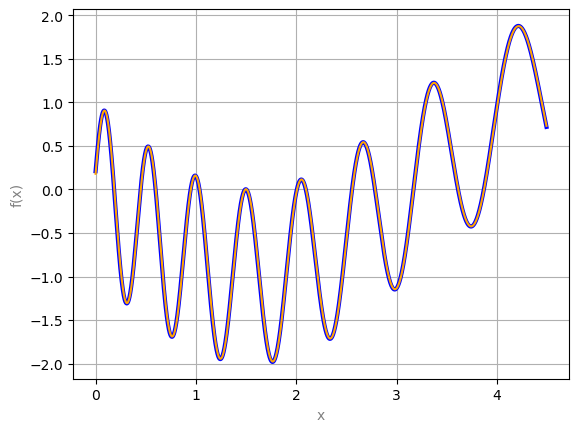

In [88]:
D = 5
train_X,train_Y = make_dataset(line,D)

model = torch.nn.Sequential(
    nn.Linear(D,1),
    nn.Flatten(0,1)
)

arr = train(model,train_X,train_Y,100,100,0.01,accuracy = accuracy_adaline)

plot_both(train_Y,model(train_X).detach().numpy())

## Вывод

В ходе выполнения этой лабораторной работы я ознакомился с классификатором adaline и решил с его помощью задачу аппроксимации и фильтрации сигнала. Я исследовал зависимость точности аппроксимации от ширины окна и зависимость точности фильтрации от длины той части целевой функции, которая используется при обучении. Так как я не сразу осознал, что функция активации adaline линейная и пытался обучить модель с другими функциями, получая своеобразные результаты, мне стало интересно, как она поведет себя при использовании различных активационных функций, и я попробовал проследить зависимость между функцией акивации и характером вывода модели, и в процессе на примере понял, почему в модели adaline исользуется линейная функция активации.
